## Импортирование библиотек и загрузка данных

In [3]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
file = files.upload()

Saving stopwords.txt to stopwords.txt


In [30]:
!ls

articles.csv  sample_data  stopwords.txt  users_articles.csv  users_churn.csv


Наши новости

In [7]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [8]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### Получаем векторные представления новостей

In [9]:
from gensim.corpora.dictionary import Dictionary

In [11]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 8.2MB 8.7MB/s 


In [14]:
!pip install razdel

In [15]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize

import pymorphy2  # pip install pymorphy2

In [25]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

стоп-слова

In [26]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [31]:
with open('stopwords.txt', encoding='utf-8') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [32]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [33]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 17.5 s, sys: 1.04 s, total: 18.5 s
Wall time: 18.5 s


In [34]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 2min 51s, sys: 115 ms, total: 2min 51s
Wall time: 2min 51s


### модель

In [35]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [36]:
common_dictionary[15]

'генералполковник'

обучение

In [37]:
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [38]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [39]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(12, 0.4903457), (14, 0.31696624), (20, 0.084134854), (24, 0.08806546)]

### Какие получились темы

In [40]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: исследователь древний учёный век nn птица ссср
topic_1: фонд сколково журнал популярный уголь геном марс
topic_2: газ поверхность следствие уголовный кровь nn обвинение
topic_3: реформа механизм египет пресссекретарить мкс экспедиция nn
topic_4: россия информация сотрудник сша российский источник глава
topic_5: обнаружить животное эксперимент конкурс музей узнать всё
topic_6: земля ракета запуск северный пуск орбита иск
topic_7: россия nn наука гражданин российский правительство санкция
topic_8: американский спутник нефть война остров государство лидер
topic_9: россия население район всё журнал эксперт регион
topic_10: млрд банк рубль цена экономика руб объём
topic_11: писать астроном памятник век первый русский nn
topic_12: луна автор nn первый виза мир испания
topic_13: тело статья мозг рак выяснить болезнь жертва
topic_14: погибнуть восток дыра физика бомба годовой сенатор
topic_15: самолёт военный корабль российский экипаж полёт войско
topic_16: рынок проект система рост н

### функция, которая будет нам возвращать векторное представление новости

In [41]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [42]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.046311,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.083935,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.862360,0.000000
1,4896,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.295502,0.0,0.142461,0.0,0.0,0.0,0.0,0.041912,0.000000,0.06016,0.440452,0.000000,0.000000
2,4897,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.490274,0.0,0.316758,0.0,0.0,0.0,0.0,0.000000,0.084329,0.00000,0.000000,0.000000,0.088151
3,4898,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.019671,0.087929,0.0,0.0174,0.000000,0.0,0.645532,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.197864,0.022558
4,4899,0.341108,0.0,0.0,0.0,0.115603,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.090181,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.038966,0.392520,0.000000


### Векторные представления пользователей

In [43]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [44]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [45]:
doc_dict[293627]

array([0.02478166, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0351144 , 0.        , 0.        , 0.        ,
       0.        , 0.1745605 , 0.        , 0.        , 0.        ,
       0.        , 0.0360796 , 0.03576087, 0.        , 0.        ,
       0.        , 0.48045024, 0.19379327, 0.        , 0.        ])

In [46]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [47]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.07271003, 0.01937039, 0.12769972,
       0.        , 0.01313098, 0.17601094, 0.09646354, 0.02387204,
       0.00265731, 0.00394041, 0.00834498, 0.04511901, 0.        ,
       0.07711333, 0.03449297, 0.02048378, 0.        , 0.01227942,
       0.01004896, 0.05686744, 0.01046088, 0.06974763, 0.10743468])

In [48]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [49]:
" ".join(news[news['doc_id']==323183]['title'].iloc[0])

'владимир путин убрать всё препона мешать россиянин усыновлять сирота краткий срок риа новость nn правительство принять ряд решение отдельный острый проблема пока остаться неурегулированный нужно убрать всё препона мешать гражданин желать принять ребёнок семья путин заседание совет реализация приоритетный национальный проект демографический политика nn федеральный уровень отсутствовать примерный порядок срок подготовка гражданин приём ребёнок семья поручать правительство краткий срок урегулировать всё проблема подчеркнуть путин подписать указ увеличение социальный выплата безработный родитель воспитывать ребёнок подписать указ существенно повышать социальный выплата неработающий родитель воспитывать детейинвалид возраст инвалид детство независимо возраст путин объяснить размер выплата составить тысяча рубль рассчитываться поручить разработать предложение программа материнский капитал перестать действовать мера поддержка семья установленный срок реализация программа материнский капитал 

In [50]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.040559,0.005453,0.021326,0.054038,0.092553,0.054276,0.000000,0.048232,0.063797,0.039738,0.024919,0.050721,0.020498,0.022879,0.009559,0.016052,0.00000,0.001730,0.075331,0.022719,0.049680,0.065522,0.102953,0.053356,0.051013
1,u108690,0.000000,0.000000,0.023837,0.034108,0.152811,0.041150,0.012446,0.062836,0.101780,0.079626,0.021520,0.008584,0.000000,0.014282,0.000000,0.000000,0.06018,0.005801,0.081876,0.014278,0.026002,0.043123,0.013963,0.071385,0.109312
2,u108339,0.000000,0.000000,0.085452,0.007020,0.122337,0.002689,0.016209,0.113395,0.126515,0.073723,0.015784,0.004862,0.016016,0.048058,0.023486,0.014977,0.06453,0.007226,0.005190,0.029978,0.047832,0.043302,0.017615,0.026468,0.068708


### Разметка датасета

In [51]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [52]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.040559,0.005453,0.021326,0.054038,0.092553,0.054276,0.000000,0.048232,0.063797,0.039738,0.024919,0.050721,0.020498,0.022879,0.009559,0.016052,0.00000,0.001730,0.075331,0.022719,0.049680,0.065522,0.102953,0.053356,0.051013,0
1,u108690,0.000000,0.000000,0.023837,0.034108,0.152811,0.041150,0.012446,0.062836,0.101780,0.079626,0.021520,0.008584,0.000000,0.014282,0.000000,0.000000,0.06018,0.005801,0.081876,0.014278,0.026002,0.043123,0.013963,0.071385,0.109312,1
2,u108339,0.000000,0.000000,0.085452,0.007020,0.122337,0.002689,0.016209,0.113395,0.126515,0.073723,0.015784,0.004862,0.016016,0.048058,0.023486,0.014977,0.06453,0.007226,0.005190,0.029978,0.047832,0.043302,0.017615,0.026468,0.068708,1


### Подготавливаем данные

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [54]:
X_test

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
3069,0.005311,0.004354,0.055036,0.002436,0.149982,0.000000,0.083421,0.164371,0.072728,0.033643,0.081613,0.027895,0.000000,0.018888,0.002858,0.027476,0.091877,0.018555,0.002311,0.060511,0.002593,0.044759,0.002025,0.012187,0.025804
1675,0.058240,0.018977,0.005998,0.018684,0.045845,0.056639,0.000000,0.023293,0.032842,0.031262,0.000000,0.079221,0.040214,0.051782,0.010420,0.000000,0.019905,0.002322,0.017548,0.018526,0.011322,0.072581,0.314301,0.006722,0.043865
6385,0.014172,0.034121,0.043494,0.008546,0.106606,0.041057,0.008078,0.074227,0.019359,0.056308,0.018472,0.018309,0.009941,0.063981,0.035852,0.003585,0.061838,0.070445,0.000000,0.046146,0.066344,0.077157,0.032161,0.005009,0.066481
543,0.032209,0.002673,0.086052,0.081051,0.160537,0.016451,0.028490,0.080599,0.032319,0.035100,0.000000,0.000000,0.003908,0.009567,0.006608,0.011765,0.079684,0.004748,0.033445,0.104713,0.026391,0.026716,0.005904,0.035119,0.086106
3213,0.105327,0.014876,0.006427,0.030264,0.085695,0.033860,0.005616,0.124264,0.163383,0.018485,0.000000,0.016212,0.030855,0.023224,0.033094,0.000000,0.106208,0.011648,0.000000,0.000000,0.003394,0.027244,0.010860,0.066207,0.071541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,0.003824,0.000000,0.000000,0.037069,0.049531,0.013434,0.052354,0.151832,0.238320,0.036194,0.019625,0.008392,0.008077,0.037000,0.036233,0.000000,0.053750,0.010972,0.000000,0.092315,0.000000,0.054561,0.018590,0.027005,0.038714
2913,0.106096,0.108157,0.053147,0.018183,0.044718,0.059304,0.000000,0.106080,0.006357,0.009314,0.028851,0.053856,0.010755,0.009175,0.021241,0.021145,0.005196,0.031130,0.011823,0.035623,0.015553,0.017375,0.152233,0.010699,0.048821
6150,0.056693,0.048704,0.000000,0.033267,0.015820,0.110406,0.000000,0.052153,0.037856,0.020372,0.026421,0.000000,0.101965,0.008457,0.092489,0.000000,0.052645,0.012194,0.158100,0.003293,0.047139,0.058061,0.000000,0.000000,0.042325
7213,0.014558,0.052479,0.050200,0.015896,0.123092,0.040991,0.011335,0.150399,0.152059,0.017682,0.025340,0.065332,0.007884,0.018800,0.000000,0.026690,0.026220,0.000000,0.000000,0.003920,0.000000,0.024692,0.007807,0.027340,0.127797


In [55]:
X_train

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
286,0.071871,0.024067,0.024098,0.006852,0.060983,0.132934,0.006456,0.107644,0.000000,0.000000,0.012974,0.042724,0.047804,0.025095,0.012409,0.012515,0.024760,0.000000,0.017443,0.042442,0.039948,0.023461,0.229527,0.000000,0.022297
6696,0.013537,0.060121,0.000000,0.011865,0.028000,0.045826,0.000000,0.012910,0.000000,0.166477,0.014926,0.000000,0.085446,0.018097,0.298786,0.000000,0.000000,0.021287,0.011325,0.040466,0.058888,0.000000,0.000000,0.034884,0.062676
6486,0.068681,0.007711,0.018172,0.000000,0.000000,0.007011,0.040820,0.007032,0.022666,0.113759,0.002364,0.012665,0.078541,0.041026,0.144090,0.000000,0.008525,0.031058,0.000000,0.003184,0.282616,0.020676,0.007137,0.021590,0.047755
1145,0.000000,0.000000,0.001990,0.001955,0.045691,0.000000,0.025863,0.004214,0.004442,0.032982,0.057449,0.000000,0.052010,0.000000,0.330104,0.000000,0.109580,0.037287,0.000000,0.010913,0.004090,0.081626,0.000000,0.124047,0.055156
6346,0.020593,0.055849,0.011444,0.005882,0.006965,0.003365,0.039792,0.002314,0.008993,0.000000,0.000000,0.020890,0.052947,0.010172,0.258416,0.011478,0.014947,0.116198,0.063260,0.011786,0.053072,0.005814,0.005235,0.008118,0.192003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0.003973,0.007271,0.092891,0.016088,0.133263,0.056290,0.017875,0.133734,0.055004,0.038525,0.016883,0.014888,0.005113,0.015324,0.006023,0.063365,0.084340,0.006514,0.088783,0.020652,0.012241,0.025521,0.002832,0.020322,0.051828
3264,0.003249,0.002597,0.007169,0.019269,0.003875,0.011785,0.010303,0.006932,0.010671,0.026143,0.045215,0.000000,0.011891,0.028142,0.448673,0.000000,0.010013,0.030184,0.018803,0.000000,0.110665,0.009443,0.008973,0.027066,0.134368
1653,0.034790,0.007266,0.020840,0.015089,0.216480,0.005089,0.000000,0.133052,0.027362,0.014072,0.088958,0.034654,0.000000,0.024638,0.000000,0.038303,0.055578,0.049336,0.000000,0.043101,0.012173,0.058200,0.000000,0.004230,0.104001
2607,0.024849,0.005618,0.004794,0.006812,0.027025,0.097582,0.000000,0.009271,0.025728,0.012823,0.003735,0.015452,0.094600,0.029456,0.315850,0.004868,0.023184,0.025305,0.019991,0.030753,0.029054,0.004543,0.052802,0.037183,0.083746


In [56]:
y_test

3069    0
1675    0
6385    1
543     0
3213    0
       ..
3482    0
2913    0
6150    0
7213    0
3262    0
Name: churn, Length: 2000, dtype: int64

In [57]:
y_train

286     0
6696    0
6486    0
1145    0
6346    0
       ..
4931    0
3264    0
1653    0
2607    0
2732    0
Name: churn, Length: 6000, dtype: int64

In [58]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.13528427, 0.04458247, 0.3664314 , 0.26870833, 0.02172288,
       0.05004957, 0.0568644 , 0.08306369, 0.02646275, 0.06225694])

### Рассчитаем Precision, Recall, F_score

In [76]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

mean_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

Best Threshold=0.337677, F-Score=0.783, Precision=0.745, Recall=0.824


In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1611  144]
 [  49  196]]


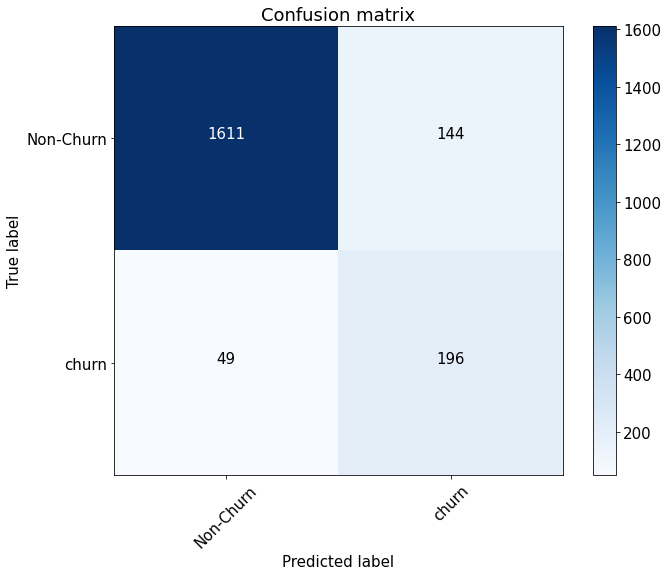

In [63]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [64]:
roc_auc_score(y_test, preds)

0.9468922611779755

### Задание

### Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision /recall/ f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve)

In [65]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.04907483,
       0.        , 0.        , 0.09413692, 0.08044349, 0.02018025,
       0.        , 0.        , 0.        , 0.01907997, 0.        ,
       0.0077376 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06587893, 0.04521015])

In [66]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

median_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

Best Threshold=0.281837, F-Score=0.817, Precision=0.843, Recall=0.792


Confusion matrix, without normalization
[[1719   36]
 [  52  193]]


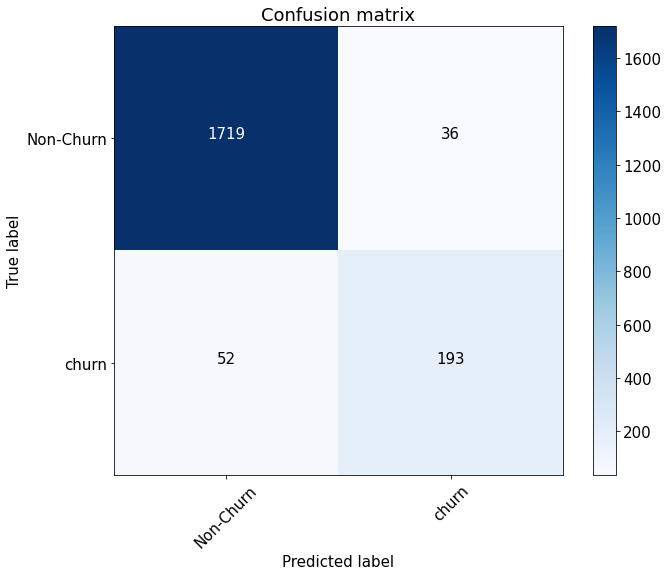

In [67]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.show()

In [68]:
roc_auc_score(y_test, preds)

0.9786615500901215

используя уже не медиану, а max

In [69]:
user_articles_list = users['articles'].iloc[33]
# print(user_articles_list)

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = np.max(user_vector, 0)
#     print('\nuser_vector', user_vector)
    return user_vector

get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.43626016, 0.10298005, 0.5724991 ,
       0.        , 0.06594134, 0.50842184, 0.26885688, 0.05375324,
       0.01594388, 0.02364243, 0.05006991, 0.11730843, 0.        ,
       0.27070373, 0.15510303, 0.09754732, 0.        , 0.04346093,
       0.06029374, 0.27249935, 0.06276526, 0.17674416, 0.45278201])

In [70]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

max_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

Best Threshold=0.337677, F-Score=0.783, Precision=0.745, Recall=0.824


In [71]:
fscore[ix]

0.7829457364341086

Confusion matrix, without normalization
[[1686   69]
 [  44  201]]


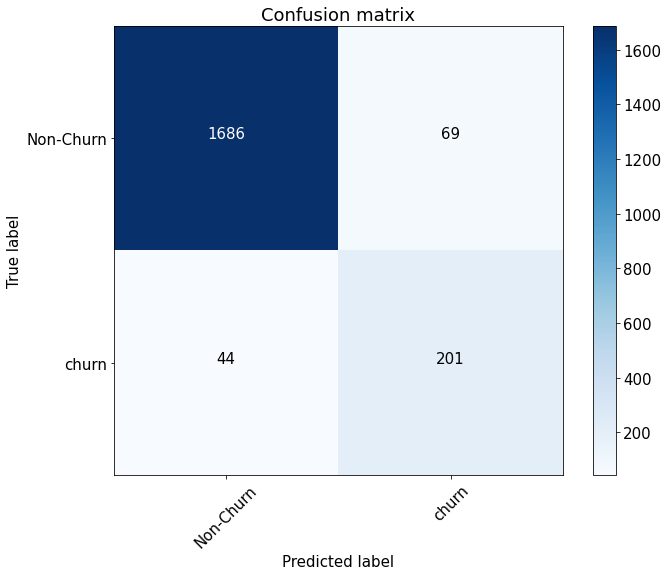

In [72]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.show()

In [73]:
roc_auc_score(y_test, preds)

0.9730658759230186

### Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [77]:
summary_table = pd.DataFrame({'mean': mean_rating, 'median': median_rating, 'max': max_rating}).T
summary_table.columns=['f1_score', 'precision', 'recall', 'roc_auc_score']
summary_table

,f1_score,precision,recall,roc_auc_score
mean,0.782946,0.745387,0.824490,0.973066
median,0.816842,0.843478,0.791837,0.978662
max,0.782946,0.745387,0.824490,0.973066


## По значению roc_auc лучше всего показаля себя медиана, но не сильно лучше максимума, зато максимум с медианой значительно обошли среднее. Зато True Negative и False Negative лучше чем у остальных.